Источники:
https://linuxtut.com/en/7b91474430c1f190c470/

In [1]:
import sys
import os
import shutil
import pandas as pd
import requests
from sklearn.utils import Bunch
from tqdm.auto import tqdm

In [2]:
# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift catboost pandas

     |████████████████████████████████| 76.4 MB 27 kB/s 


In [3]:
def _download(url, dest_path, content_length_header_key='Content-Length'):
    """Download the file from url and save it locally.
    Args:
        url (str): URL address, must be a string.
        dest_path (str): Destination of the file.
        content_length_header_key (str): The key in the HTTP response headers that lists the response size in bytes.
            Used for progress bar.
    """
    if isinstance(url, str):
        req = requests.get(url, stream=True)
        req.raise_for_status()

        with open(dest_path, "wb") as fd:
            total_size_in_bytes = int(req.headers.get(content_length_header_key, 0))
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            for chunk in req.iter_content(chunk_size=2 ** 20):
                progress_bar.update(len(chunk))
                fd.write(chunk)
    else:
        raise TypeError("URL must be a string")

In [4]:
def _create_data_dir(path):
    """Creates a directory, which stores the datasets.
    Args:
        path (str): The path to scikit-uplift data dir.
    """
    if not os.path.isdir(path):
        os.makedirs(path)

In [5]:
def get_data_dir():
    """Return the path of the scikit-uplift data dir.
    This folder is used by some large dataset loaders to avoid downloading the data several times.
    By default the data dir is set to a folder named ``scikit-uplift-data`` in the user home folder.
    Returns:
        string: The path to scikit-uplift data dir.
    """
    return os.path.join(os.path.expanduser("~"), "scikit-uplift-data")

In [6]:
def _get_data(data_home, url, dest_subdir, dest_filename, download_if_missing,
              content_length_header_key='Content-Length'):
    """Return the path to the dataset.
    Args:
        data_home (str): The path to scikit-uplift data dir.
        url (str): The URL to the dataset.
        dest_subdir (str): The name of the folder in which the dataset is stored.
        dest_filename (str): The name of the dataset.
        download_if_missing (bool): If False, raise a IOError if the data is not locally available instead of
            trying to download the data from the source site.
        content_length_header_key (str): The key in the HTTP response headers that lists the response size in bytes.
            Used for progress bar.
    Returns:
        string: The path to the dataset.
    """
    if data_home is None:
        if dest_subdir is None:
            data_dir = get_data_dir()
        else:
            data_dir = os.path.join(get_data_dir(), dest_subdir)
    else:
        if dest_subdir is None:
            data_dir = os.path.abspath(data_home)
        else:
            data_dir = os.path.join(os.path.abspath(data_home), dest_subdir)

    _create_data_dir(data_dir)

    dest_path = os.path.join(data_dir, dest_filename)
    print(not os.path.isfile(dest_path))
    if not os.path.isfile(dest_path):
        if download_if_missing:
            _download(url, dest_path, content_length_header_key)
        else:
            raise IOError("Dataset missing")
    return dest_path

In [7]:
def fetch_x5(data_home=None, dest_subdir=None, download_if_missing=True):
    """Load and return the X5 RetailHero dataset (classification).
    The dataset contains raw retail customer purchases, raw information about products and general info about customers.
    Major columns:
    - ``treatment_flg`` (binary): treatment/control group flag
    - ``target`` (binary): target
    - ``customer_id`` (str): customer id - primary key for joining
    Read more in the :ref:`docs <X5>`.
    Args:
        data_home (str, unicode): The path to the folder where datasets are stored.
        dest_subdir (str, unicode): The name of the folder in which the dataset is stored.
        download_if_missing (bool): Download the data if not present. Raises an IOError if False and data is missing
    Returns:
        Bunch: dataset.
         Dictionary-like object, with the following attributes.
            * ``data`` (Bunch object): dictionary-like object without target and treatment:
                * ``clients`` (ndarray or DataFrame object): General info about clients.
                * ``train`` (ndarray or DataFrame object): A subset of clients for training.
                * ``purchases`` (ndarray or DataFrame object): clients’ purchase history prior to communication.
            * ``target`` (Series object): Column target by values.
            * ``treatment`` (Series object): Column treatment by values.
            * ``DESCR`` (str): Description of the X5 dataset.
            * ``feature_names`` (Bunch object): Names of the features.
            * ``target_name`` (str): Name of the target.
            * ``treatment_name`` (str): Name of the treatment.
    References:
        https://ods.ai/competitions/x5-retailhero-uplift-modeling/data
    Example::
        from sklift.datasets import fetch_x5
        dataset = fetch_x5()
        data, target, treatment = dataset.data, dataset.target, dataset.treatment
        # data - dictionary-like object
        # data contains general info about clients:
        clients = data.clients
        # data contains a subset of clients for training:
        train = data.train
        # data contains a clients’ purchase history prior to communication.
        purchases = data.purchases
    See Also:
        :func:`.fetch_lenta`: Load and return the Lenta dataset (classification).
        :func:`.fetch_criteo`: Load and return the Criteo Uplift Prediction Dataset (classification).
        :func:`.fetch_hillstrom`: Load and return Kevin Hillstrom Dataset MineThatData (classification or regression).
        :func:`.fetch_megafon`: Load and return the MegaFon Uplift Competition dataset (classification).
    """
    #print(csv_train_path)
    train = pd.read_csv('/content/drive/MyDrive/uplift_data/uplift_train.csv')
    train_features = list(train.columns)

    #print(train_features)
    target_col = 'target'
    treatment_col = 'treatment_flg'

    treatment, target = train[treatment_col], train[target_col]

    train = train.drop([target_col, treatment_col], axis=1)

    clients = pd.read_csv('/content/drive/MyDrive/uplift_data/clients.csv')
    clients_features = list(clients.columns)


    purchases = pd.read_csv('/content/drive/MyDrive/uplift_data/purchases.csv')
    purchases_features = list(purchases.columns)

    data = Bunch(clients=clients, train=train, purchases=purchases)
    feature_names = Bunch(train_features=train_features, clients_features=clients_features,
                          purchases_features=purchases_features)

    module_path = os.path.dirname('__file__')
    with open(os.path.join(module_path, 'descr', 'x5.rst')) as rst_file:
        fdescr = rst_file.read()

    return Bunch(data=data, target=target, treatment=treatment, DESCR=fdescr,
                 feature_names=feature_names, target_name='target', treatment_name='treatment_flg')

In [8]:
from sklearn.model_selection import train_test_split
#from sklift.datasets import fetch_x5
import pandas as pd
import sklift
pd.set_option('display.max_columns', None)
%matplotlib inline

In [9]:
dataset = fetch_x5()
dataset.data.keys()

dict_keys(['clients', 'train', 'purchases'])

Сводная информация о данных (их размер)

In [10]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data['clients'].shape}")
print(f"Dataset features shape: {dataset.data['train'].shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (400162, 5)
Dataset features shape: (200039, 1)
Dataset target shape: (200039,)
Dataset treatment shape: (200039,)


Предобработка данных

In [11]:
# Извлечение данных
df_clients = dataset.data['clients'].set_index("client_id")
df_train = pd.concat([dataset.data['train'], dataset.treatment , dataset.target], axis=1).set_index("client_id")
indices_test = pd.Index(set(df_clients.index) - set(df_train.index))

# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

Объявление переменных

In [12]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[df_train.index, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

#категориальная переменная
cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

## 1. Подходы с одной моделью

### 1.1 Одна модель с признаком коммуникации

Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.


<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/SoloModel_RU.png" alt="Solo model with treatment as a feature"/>
</p>

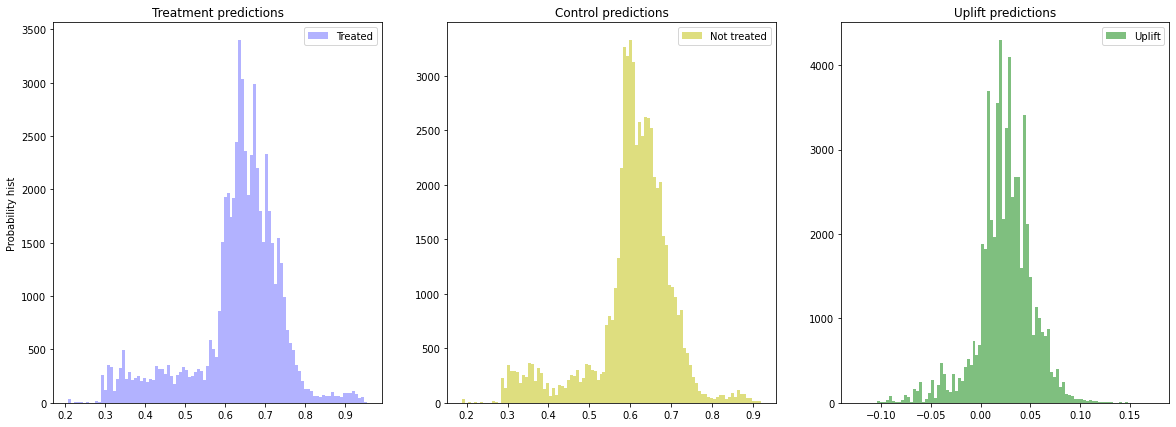

In [13]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier
#Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
#Обучение модель в соответствии с заданными данными обучения. Для каждого тестового примера рассчитайте прогнозы для нового набора дважды: по первой и второй моделям. 
#После этого рассчитайте подъем как дельту между этими прогнозами. Возвращает дельту прогнозов для каждого примера.
#Вектор двоичной обработки относительно X.
#Параметры для передачи в метод подгонки оценщика.
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)
#Вычислите uplift для первых k наблюдений путем увеличения всей выборки.
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [15]:
X_train_cat_boost = X_train.replace('F', 1).replace("M", 0).replace("U", 2)
X_train_cat_boost
X_val_cat_boost = X_val.replace('F', 1).replace("M", 0).replace("U", 2)


0.05726192634218552 0.16666666666666669


In [17]:
model_cat_boost = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
model_cat_boost.fit(X_train_cat_boost, y_train)
upflit_sm_cat_boost = model_cat_boost.predict(X_val_cat_boost)
sm_score_cat_boost = uplift_at_k(y_true=y_val, uplift=upflit_sm_cat_boost, treatment=treat_val, strategy='by_group', k=0.3)
print(sm_score, sm_score_cat_boost)

0.05726192634218552 0.03757036969898386


In [18]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,41.162563
1,issue_redeem_delay,38.676225
2,age,8.003793
3,first_issue_time,6.274424
4,treatment,3.431789
5,gender,2.451207


### 1.2 Трансформация классов

Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),
$$
где 

* $Z_i$ - новая целевая переменная $i$-ого клиента; 
* $Y_i$ - целевая перемнная $i$-ого клиента;
* $W_i$ - флаг коммуникации $i$-ого клиента;  


Другими словами, новый класс равен 1, если мы знаем, что на конкретном наблюдении, результат при взаимодействии был бы таким же хорошим, как и в контрольной группе, если бы мы могли знать результат в обеих группах:

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

Распишем подробнее, чему равна вероятность новой целевой переменной:

$$ 
P(Z=1|X = x) = \\
= P(Z=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Z=1|X = x, W = 0) \cdot P(W = 0|X = x) = \\
= P(Y=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Y=0|X = x, W = 0) \cdot P(W = 0|X = x).
$$

Выше мы обсуждали, что обучающая выборка для моделирования uplift собирается на основе рандомизированного разбиения части клиенской базы на тестовую и контрольную группы. Поэтому коммуникация $ W $ не может зависить от признаков клиента $ X_1, ..., X_m $. Принимая это, мы имеем: $ P(W | X_1, ..., X_m, ) = P(W) $ и 

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot P(W = 1) + \\
+ P^C(Y=0|X = x) \cdot P(W = 0)
$$

Также допустим, что $P(W = 1) = P(W = 0) = \frac{1}{2}$, т.е. во время эксперимента контрольные и тестовые группы были разделены в равных пропорциях. Тогда получим следующее:

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot \frac{1}{2} + P^C(Y=0|X = x) \cdot \frac{1}{2} \Rightarrow \\
2 \cdot P(Z=1|X = x) = \\
= P^T(Y=1|X = x) + P^C(Y=0|X = x) = \\
= P^T(Y=1|X = x) + 1 - P^C(Y=1|X = x) \Rightarrow \\
\Rightarrow P^T(Y=1|X = x) - P^C(Y=1|X = x) = \\
 = uplift = 2 \cdot P(Z=1|X = x) - 1
$$

Таким образом, увеличив вдвое прогноз нового таргета и вычтя из него единицу мы получим значение самого uplift'a, т.е.

$$
uplift = 2 \cdot P(Z=1) - 1
$$

Исходя из допущения описанного выше: $P(W = 1) = P(W = 0) = \frac{1}{2}$, данный подход следует использовать только в случаях, когда количество клиентов, с которыми мы прокоммуницировлаи, равно количеству клиентов, с которыми коммуникации не было. 

In [16]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

## 2. Подходы с двумя моделями

Подход с двумя моделями можно встретить почти в любой работе по uplift моделированию, он часто используется в качестве бейзлайна. Однако использование двух моделей может привести к некоторым неприятным последствиям: если для обучения будут использоваться принципиально разные модели или природа данных тестовой и контрольной групп будут сильно отличаться, то возвращаемые моделями скоры  будут не сопоставимы между собой. Вследствие чего расчет uplift будет не совсем корректным. Для избежания такого эффекта необходимо калибровать модели, чтобы их скоры можно было интерпертировать как вероятности. Калибровка вероятностей модели отлично описана в [документации scikit-learn](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Две независимые модели

Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila_RU.png" alt="Two Models vanila"/>
</p>

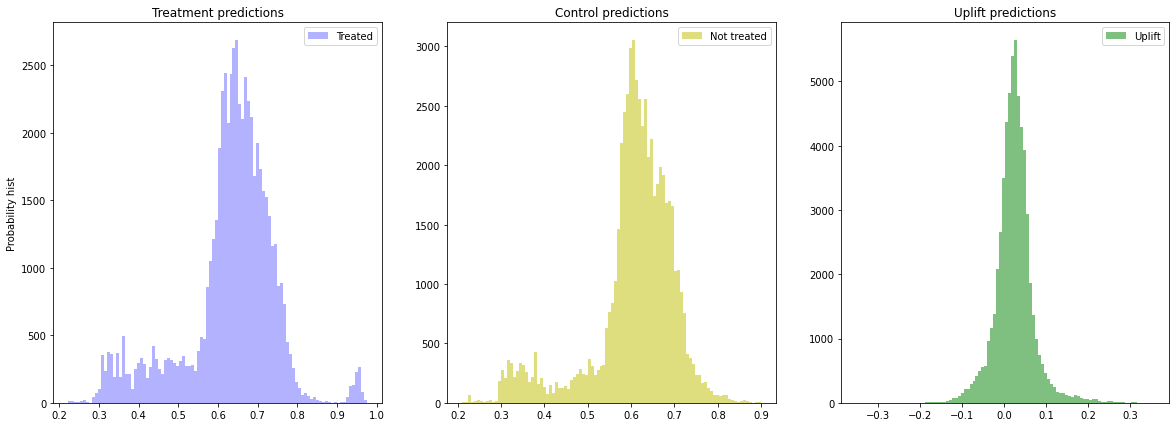

In [17]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 2.2 Две зависимые модели

Подход зависимого представления данных основан на методе цепочек классификаторов, первоначально разработанном для задач многоклассовой классификации. Идея состоит в том, что при наличии $L$ различных меток можно построить $L$ различных классификаторов, каждый из которых решает задачу бинарной классификации и в процессе обучения каждый следующий классификатор использует предсказания предыдущих в качестве дополнительных признаков. Авторы данного метода предложили использовать ту же идею для решения проблемы uplift моделирования в два этапа. В начале мы обучаем классификатор по контрольным данным: 
$$
P^C = P(Y=1| X, W = 0),
$$
затем исполним предсказания $P_C$ в качестве нового признака для обучения второго классификатора на тестовых данных, тем самым эффективно вводя зависимость между двумя наборами данных:

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

Чтобы получить uplift для каждого наблюдения, вычислим разницу:

$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

Интуитивно второй классификатор изучает разницу между ожидаемым результатом в тесте и контроле, т.е. сам uplift.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control_RU.png" alt="Two dependent models"/>
</p>

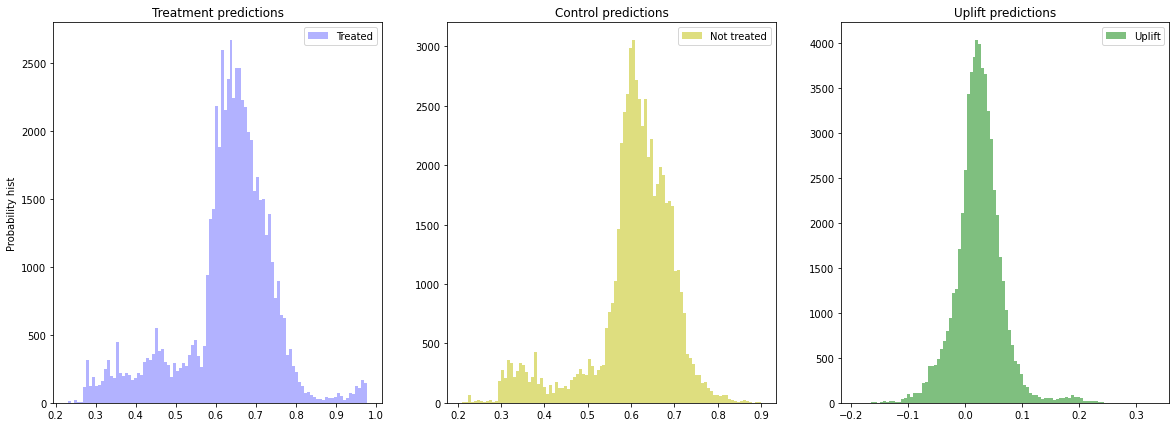

In [18]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

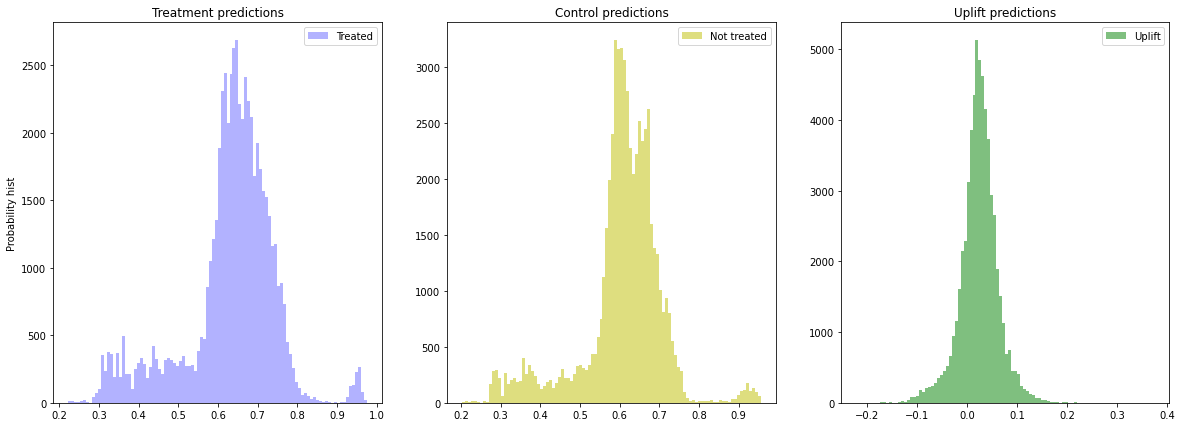

In [19]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Заключение

Рассмотрим, какой метод лучше всего показал себя в этой задаче, и проскорим им тестовую выборку:

In [20]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.057262
1,ClassTransformation,0.053981
3,TwoModels_ddr_control,0.053118
2,TwoModels,0.049310
4,TwoModels_ddr_treatment,0.033900


Из таблички выше можно понять, что в текущей задаче лучше всего справился подход трансформации целевой перемнной. Обучим модель на всей выборке и предскажем на тест.

In [21]:
ct_full = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct_full = ct_full.fit(
    X_train_full, 
    y_train_full, 
    treat_train_full, 
    estimator_fit_params={'cat_features': cat_features}
)

X_test.loc[:, 'uplift'] = ct_full.predict(X_test.values)

sub = X_test[['uplift']].to_csv('sub1.csv')

!head -n 5 sub1.csv

,uplift
e4efae9762,0.08096756982178954
5946a275b9,0.05885397001401671
286346afe6,0.07902313487042067
e3c029de47,0.01860180662794031


In [22]:
ct_full_fi = pd.DataFrame({
    'feature_name': ct_full.estimator.feature_names_,
    'feature_score': ct_full.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_full_fi

,feature_name,feature_score
0,first_redeem_time,83.045912
1,age,6.623155
2,first_issue_time,4.059862
3,issue_redeem_delay,4.022845
4,gender,2.248227


Итак, мы познакомились с uplift моделированием и рассмотрели основные классические подходы его построения. Что дальше? Дальше можно с головй окунуться в разведывательный анализ данных, генерацию новых признаков, подбор моделей и их гиперпарметров, а также изучение новых подходов и библиотек.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import random

from sklearn.linear_model import LogisticRegression
#--Generation of data to be used

#The profit here is CVR.

def generate_sample_data(num, seed=0):
    cv_flg_list = [] #A list of flags that indicate conversions
    treat_flg_list = [] #A list of flags that indicate whether you have intervened
    feature_vector_list = [] #List of features
    
    feature_num = 8 #Number of features
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00] #Feature base
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.0, 0.00] #Amount of change in features during intervention
    
    random_instance = random.Random(seed)
    for i in range(num):
        feature_vector = [random_instance.random() for n in range(feature_num)] #Randomly generate features
        treat_flg = random_instance.choice((1, 0)) #Randomly generate intervention flags
        cv_rate = sum([feature_vector[n]*base_weight[n] for n in range(feature_num)]) #Generate the base value of CVR
        if treat_flg == 1:
            cv_rate += sum([feature_vector[n]*lift_weight[n] for n in range(feature_num)]) #Lift if you want to intervene_Add weight and add CVR
        cv_flg = 1 if cv_rate > random_instance.random() else 0
        
        cv_flg_list.append(cv_flg)
        treat_flg_list.append(treat_flg)
        feature_vector_list.append(feature_vector)
    
    df = pd.DataFrame(np.c_[cv_flg_list, treat_flg_list, feature_vector_list], 
                      columns=['cv_flg', 'treat_flg','feature0', 'feature1', 'feature2', 
                               'feature3', 'feature4', 'feature5', 'feature6', 'feature7'])
    
    return df

train_data = generate_sample_data(num=10000, seed=0) #Model building data (learning data)
test_data = generate_sample_data(num=10000, seed=1) #Model performance evaluation data (verification data

In [22]:
#Prepare data for the model to predict the benefit (CVR) of intervention
X_train_treat = train_data[train_data['treat_flg']==1].drop(['cv_flg', 'treat_flg'], axis=1)
Y_train_treat = train_data.loc[train_data['treat_flg']==1, 'cv_flg']

#Prepare data for the model to predict the benefit (CVR) without intervention
X_train_control = train_data[train_data['treat_flg']==0].drop(['cv_flg', 'treat_flg'], axis=1)
Y_train_control = train_data.loc[train_data['treat_flg']==0, 'cv_flg']

#Build two models
treat_model = LogisticRegression(C=0.01, random_state=0)
control_model = LogisticRegression(C=0.01, random_state=0)
treat_model.fit(X_train_treat, Y_train_treat)
control_model.fit(X_train_control, Y_train_control)

#Predict CVR for validation data
X_test = test_data.drop(['cv_flg', 'treat_flg'], axis=1)

treat_score = treat_model.predict_proba(X_test)[:, 1]
control_score = control_model.predict_proba(X_test)[:, 1]

#Calculate uplift score
uplift_score = treat_score - control_score

In [23]:
#Sort the validation data in descending order of uplift score
result = pd.DataFrame(np.c_[test_data['cv_flg'], test_data['treat_flg'], uplift_score], columns=['cv_flg', 'treat_flg', 'uplift_score'])
result = result.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)

#Calculation of lift
result['treat_num_cumsum'] = result['treat_flg'].cumsum()
result['control_num_cumsum'] = (1 - result['treat_flg']).cumsum()
result['treat_cv_cumsum'] = (result['treat_flg'] * result['cv_flg']).cumsum()
result['control_cv_cumsum'] = ((1 - result['treat_flg']) * result['cv_flg']).cumsum()
result['treat_cvr'] = (result['treat_cv_cumsum'] / result['treat_num_cumsum']).fillna(0)
result['control_cvr'] = (result['control_cv_cumsum'] / result['control_num_cumsum']).fillna(0)
result['lift'] = (result['treat_cvr'] - result['control_cvr']) * result['treat_num_cumsum']
result['base_line'] = result.index * result['lift'][len(result.index) - 1] / len(result.index)

#Calculation of AUUC
auuc = (result['lift'] - result['base_line']).sum() / len(result['lift'])
print('AUUC = {:.2f}'.format(auuc))
#output:=> AUUC = 37.70

AUUC = 37.70


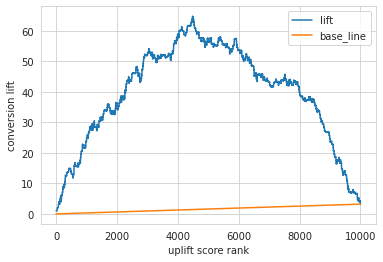

In [24]:
result.plot(y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')
plt.show()

In [26]:
#Preparation of learning data (create an interaction term between the presence or absence of intervention and features)
X_train = train_data.drop('cv_flg', axis=1)
for feature in ['feature'+str(i) for i in range(8)]:
    X_train['treat_flg_x_' + feature] = X_train['treat_flg'] * X_train[feature]
Y_train = train_data['cv_flg']

#Build a model
model = LogisticRegression(C=0.01, random_state=0)
model.fit(X_train, Y_train)

#Preparation of verification data when intervening
X_test_treat = test_data.drop('cv_flg', axis=1).copy()
X_test_treat['treat_flg'] = 1
for feature in ['feature'+str(i) for i in range(8)]:
    X_test_treat['treat_flg_x_' + feature] = X_test_treat['treat_flg'] * X_test_treat[feature]

#Preparation of verification data when no intervention is required
X_test_control = test_data.drop('cv_flg', axis=1).copy()
X_test_control['treat_flg'] = 0
for feature in ['feature'+str(i) for i in range(8)]:
    X_test_control['treat_flg_x_' + feature] = X_test_control['treat_flg'] * X_test_control[feature]

#Predict profit CVR for validation data
treat_score = model.predict_proba(X_test_treat)[:, 1]
control_score = model.predict_proba(X_test_control)[:, 1]

#Calculation of uplift score
uplift_score = treat_score - control_score